---

# Analise partidas League of Legends

League of Legends (*LoL*) é um jogo eletrônico online do gênero de batalha entre multijogadores.

O mapa possui 02 lados, cada time (de 05 jogadores) inicia em um dos lados. Cada time tem o objetivo de destruir o **nexus** do time adversário.

Até atingir o objetivo-principal, ambos os times se enfrentam pelo mapa, principalmente pelas 03 rotas (superior, meio e inferior), estas que possuem **torres** que defendem os avanços eminentes do time adversário.

Há uma série de objetivos paralelos que vão auxiliando os times a adquirir dinheiro, consequentemente melhorando seus equipamentos, para atingir o objetivo principal.


## Grupo:

* Lucas Picollo - 16204446
* Rafael Parola - 15200940
* Rian Bruggemann - 15101200

---

## Descrição

O projeto consiste na análise de mais de 100 mil partidas de League of Legends, dos elos Master, GrandMaster e Challenger do servidor da Korea em 2020.

O dataset foi retirado do [Kaggle](https://www.kaggle.com/) e pode ser encontrado [neste link](https://www.kaggle.com/gyejr95/league-of-legendslol-ranked-games-2020-ver1).

Pelo tamanho do conjunto de dados e por possuir colunas em formato json, o criador do dataset disponibilizou os arquivos em formato .pickle, porem as analises serao feitas atraves do arquivos csv.

---

## Importações





### Base de dados

In [1]:
from google.colab import files

files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json


ModuleNotFoundError: No module named 'google'

In [ ]:
!kaggle datasets download -d gyejr95/league-of-legendslol-ranked-games-2020-ver1
!unzip league-of-legendslol-ranked-games-2020-ver1.zip data

### Aplicação

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import json

%matplotlib inline

In [5]:
df_matches = pd.read_csv('data/match_data_version1.csv', nrows=10000)
df_matches.head()

,Unnamed: 0,gameCreation,gameDuration,gameId,gameMode,gameType,gameVersion,mapId,participantIdentities,participants,platformId,queueId,seasonId,status.message,status.status_code
0,0,1.585155e+12,1323.0,4.247263e+09,CLASSIC,MATCHED_GAME,10.6.314.4405,11.0,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",KR,420.0,13.0,NaN,NaN
1,1,1.585152e+12,1317.0,4.247156e+09,CLASSIC,MATCHED_GAME,10.6.314.4405,11.0,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",KR,420.0,13.0,NaN,NaN
2,2,1.585059e+12,932.0,4.243963e+09,CLASSIC,MATCHED_GAME,10.6.313.8894,11.0,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",KR,420.0,13.0,NaN,NaN
3,3,1.584978e+12,2098.0,4.241678e+09,CLASSIC,MATCHED_GAME,10.6.313.8894,11.0,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",KR,420.0,13.0,NaN,NaN
4,4,1.584973e+12,2344.0,4.241539e+09,CLASSIC,MATCHED_GAME,10.6.313.8894,11.0,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",KR,420.0,13.0,NaN,NaN


## Entendimento do Negócio


### Dataset jogadores por partidas

#### Analisando as dimensoes do dataset

In [6]:
df_matches.shape

(10000, 15)

#### Agrupando as partidas por modo de jogo, podemos perceber a presenca de diferentes modos de jogo:

In [7]:
df_matches.groupby('gameMode').size()

gameMode
ARAM          866
CLASSIC      8945
ONEFORALL     123
URF            66
dtype: int64

Para a análise iremos utilizar apenas dos jogos do **modo clássico**, pois os diferentes modos de jogo oferecem dinâmicas distintas entre eles, então removeremos os demais. Posteriormente removeremos os demais modos da base de dados.

Como temos em mão um dataframe serializado, ao converter para um json, acarretava em um json **não válido**, então tivemos que tratar as aspas simples ( ' ) para aspas duplas ( " )

Eh possivel perceber tambem que a coluna que representa o resultado da partida eh uma coluna textual contendo 'win' ou 'lose'

In [ ]:
df_matches['participants'].iloc[0]

Precisaremos função para substituir os valores booleanos da coluna "Win" juntamento com a troca de aspas simples para duplas, para entao conseguirmos parsear os registros para um hash.


Percebemos que para cada jogador eh gerado um id interno sendo ele um numero de 1 a 10, o que nao eh valido para identificarmos um jogador entro os demais do servidor. Para isso, precisaremos de um identificador global, que se encontra na colunda participantIdentities. 

Precisaremos de um meio de atrelar as estatisticas de um jogador em determinada partida com um o seu identificador global do servidor.


In [12]:
df_matches['participants'].head()

0    [{'participantId': 1, 'teamId': 100, 'champion...
1    [{'participantId': 1, 'teamId': 100, 'champion...
2    [{'participantId': 1, 'teamId': 100, 'champion...
3    [{'participantId': 1, 'teamId': 100, 'champion...
4    [{'participantId': 1, 'teamId': 100, 'champion...
Name: participants, dtype: object

### Dataset de estatisticas das partida

Alem da base de dados de jogos, possuimos dois datasets contendo estatisticas de cada partida, dividos entre vitorias e derrotas.**bold text**

In [14]:
df_winners = pd.read_csv('data/match_winner_data_version1.csv')
df_winners.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108829 entries, 0 to 108828
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            108829 non-null  int64  
 1   teamId                108829 non-null  int64  
 2   win                   108829 non-null  object 
 3   firstBlood            108829 non-null  bool   
 4   firstTower            108829 non-null  bool   
 5   firstInhibitor        108829 non-null  bool   
 6   firstBaron            108829 non-null  bool   
 7   firstDragon           108829 non-null  bool   
 8   firstRiftHerald       108829 non-null  bool   
 9   towerKills            108829 non-null  int64  
 10  inhibitorKills        108829 non-null  int64  
 11  baronKills            108829 non-null  int64  
 12  dragonKills           108829 non-null  int64  
 13  vilemawKills          108829 non-null  int64  
 14  riftHeraldKills       108829 non-null  int64  
 15  

Analisando a tabela de informacões sobre o time vencedor, podemos extrair as seguintes informações:

* A coluna que diz se um time foi vencedor ou não apresenta dados em formato de **string**, devemos converte-lo para **bool**
* As colunas **dominionVictoryScore** e **bans** nao serão relevantes para obtenção dos resultados esperados.

In [15]:
df_winners.head()

,Unnamed: 0,teamId,win,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,towerKills,inhibitorKills,baronKills,dragonKills,vilemawKills,riftHeraldKills,dominionVictoryScore,bans,gameId
0,0,200,Win,False,True,True,False,True,True,9,1,0,3,0,2,0,"[{'championId': 523, 'pickTurn': 6}, {'champio...",4.247263e+09
1,1,100,Win,False,False,False,False,True,True,4,0,0,2,0,2,0,"[{'championId': 523, 'pickTurn': 1}, {'champio...",4.247156e+09
2,2,200,Win,True,True,True,False,True,True,5,1,0,2,0,2,0,"[{'championId': 350, 'pickTurn': 6}, {'champio...",4.243963e+09
3,3,200,Win,True,True,False,False,False,True,6,0,1,3,0,1,0,"[{'championId': 81, 'pickTurn': 6}, {'champion...",4.241678e+09
4,4,100,Win,True,True,True,True,True,True,11,3,2,2,0,2,0,"[{'championId': 30, 'pickTurn': 1}, {'champion...",4.241539e+09


In [ ]:
df_winners.info()

#### Explicacao por coluna:

* teamId : identificador do time (100,200)
* win : resultado da partida (Win,False)
* firstBlood : primeira morte (boolean)
* firstTower : primeira torre (boolean)
* firstTower : primeiro inibidor (boolean)
* firstTower : primeiro baron (boolean)
* firstTower : primeiro dragon (boolean)
* firstTower : primeiro arauto (boolean)
* towerKills : torres destruida (integer)
* inhibitorKills : inibidores destruidos (integer)
* baronKills : barons feitos (integer)
* dragonKills : dragoes feitos (integer)
* riftHeraldKills : arautos feitos (integer)
* bans : campeoes banidos (json)
* gameId : gameId (foreign key)



Analisando a tabela de informacões sobre o time perdedor, podemos extrair as seguintes informações:

* A coluna que diz se um time foi vencedor ou não apresenta dados em formato de **string**, devemos converte-lo para **bool**
* As colunas **dominionVictoryScore** e **bans** nao serão relevantes para obtenção dos resultados esperados.

Possuimos dois arquivos diferentes com a mesma estrutura, um para os dados do **time vencedor** e outro para o **perdedor**.

Faremos a junção dos dois datasets fazendo a distrinção dos dados através da coluna **win**.

In [17]:
df_loosers = pd.read_csv('data/match_loser_data_version1.csv')
df_winners = pd.read_csv('data/match_winner_data_version1.csv')
df_winners.head()

,Unnamed: 0,teamId,win,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,towerKills,inhibitorKills,baronKills,dragonKills,vilemawKills,riftHeraldKills,dominionVictoryScore,bans,gameId
0,0,200,Win,False,True,True,False,True,True,9,1,0,3,0,2,0,"[{'championId': 523, 'pickTurn': 6}, {'champio...",4.247263e+09
1,1,100,Win,False,False,False,False,True,True,4,0,0,2,0,2,0,"[{'championId': 523, 'pickTurn': 1}, {'champio...",4.247156e+09
2,2,200,Win,True,True,True,False,True,True,5,1,0,2,0,2,0,"[{'championId': 350, 'pickTurn': 6}, {'champio...",4.243963e+09
3,3,200,Win,True,True,False,False,False,True,6,0,1,3,0,1,0,"[{'championId': 81, 'pickTurn': 6}, {'champion...",4.241678e+09
4,4,100,Win,True,True,True,True,True,True,11,3,2,2,0,2,0,"[{'championId': 30, 'pickTurn': 1}, {'champion...",4.241539e+09


---

### Objetivos

Com a analise dos dados finalizada, temos como output aos objetivos da analise, sao eles:



#### Quais campeões possuem mais counters pick?

*Counter pick* => significa que um campeão X possui desvantagens naturais (do jogo) em relação ao campeão Y, sendo desta forma, menos eficiente em batalha.

Feito uma seleção nas colunas que usaremos para analise:

* gameId
* gameDuration - tempo de duracao da partida
* gameMode - modo de jogo
* participantIdentities - identificadores do jogadores
* participants - dados sobre o jogador durante a partida

Deve ser ressaltado que existem colunas que contém dados em formato **json**, o que requer um **passo adicional** de conversão para fazermos as analises.




#### Existem jogadores que são counters de outros jogadores?

Buscaremos nos dados a relacao entre jogaores especificos para encontrar se ha alguma relacao entre eles diretamente, analisando numero de vitorias individuais.


#### Quais são as caracteristicas da partida que são mais relevantes para a decisão do time vencedor?

Encontrar as features que sao mais correlacionadas com o resultado da partida.

Com essa analise feita queremos poder, dado uma partida sem o resultado explicitado, dizer qual será o time vencedor.


## Preparação dos Dados

### Dataset de estatisticas de partidas

Selecao das colunas relevantes para a analise do dataset de partidas.

In [9]:
columns = ['gameId', 'gameMode', 'gameDuration', 'participantIdentities', 'participants']

df_matches = pd.read_csv('data/match_data_version1.csv', usecols=columns, nrows=10000)
df_matches.head()

,gameDuration,gameId,gameMode,participantIdentities,participants
0,1323.0,4.247263e+09,CLASSIC,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion..."
1,1317.0,4.247156e+09,CLASSIC,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion..."
2,932.0,4.243963e+09,CLASSIC,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion..."
3,2098.0,4.241678e+09,CLASSIC,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion..."
4,2344.0,4.241539e+09,CLASSIC,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion..."


#### Remocao dos demais modos de jogo alem do Classico.

In [10]:
df_matches.drop(df_matches[df_matches['gameMode']!= 'CLASSIC'].index, axis=0, inplace=True)
df_matches.groupby('gameMode').size()

gameMode
CLASSIC    8945
dtype: int64

#### Parser da coluna 'participants' e 'participantsIdentities'

In [12]:
df_matches['participants'] = df_matches['participants'].apply(lambda x: x.replace('False', 'false').replace('True', 'true').replace('\'', '\"'))
df_matches['participants'] = df_matches['participants'].apply(lambda x: json.loads(x))
df_matches['participants'].head()

0    [{'participantId': 1, 'teamId': 100, 'champion...
1    [{'participantId': 1, 'teamId': 100, 'champion...
2    [{'participantId': 1, 'teamId': 100, 'champion...
3    [{'participantId': 1, 'teamId': 100, 'champion...
4    [{'participantId': 1, 'teamId': 100, 'champion...
Name: participants, dtype: object

In [13]:
df_matches['participantIdentities'] = df_matches['participantIdentities'].apply(lambda x: json.loads( x.replace('False', 'false').replace('True', 'true').replace('\'', '\"')))
df_matches['participantIdentities'].head()

0    [{'participantId': 1, 'player': {'platformId':...
1    [{'participantId': 1, 'player': {'platformId':...
2    [{'participantId': 1, 'player': {'platformId':...
3    [{'participantId': 1, 'player': {'platformId':...
4    [{'participantId': 1, 'player': {'platformId':...
Name: participantIdentities, dtype: object

####  Merge de ID com estatisticas
Faremos o merge das colunas atribuindo o ID global a cada jogador e dividindo os times entre ganhadores e perdedores.

In [14]:
def merge_identity_with_stats(participant,stats):
  return {
    **stats['stats'], 
    'lane': stats['timeline']['lane'], 
    'role': stats['timeline']['role'], 
    'championId': stats['championId'], 
    "summonerName": participant["player"]["summonerName"]
  }

xs = []

# for _, match in itertools.islice(df_matches.iterrows(), 1):
for _, match in df_matches.iterrows():
  y = {
      'game': match['gameId'],
      'win_stats': {},
      'lose_stats': {}
  }
  for stats, identity in zip(match['participants'], match['participantIdentities']):
    y['win_stats' if stats['stats']['win'] else 'lose_stats'][identity["player"]["summonerName"]] = {
        **stats['stats'], 
      'lane': stats['timeline']['lane'], 
      'role': stats['timeline']['role'], 
      'championId': stats['championId'],
    }
  xs.append(y)

df_game_stats = pd.DataFrame(xs)
df_game_stats.head()


,game,win_stats,lose_stats
0,4.247263e+09,"{'곽김보태성민광희': {'participantId': 6, 'win': True,...","{'쪼렙이다말로하자': {'participantId': 1, 'win': False..."
1,4.247156e+09,"{'LPL Player': {'participantId': 1, 'win': Tru...","{'gapggg': {'participantId': 6, 'win': False, ..."
2,4.243963e+09,"{'Gen G Kellin': {'participantId': 6, 'win': T...","{'호잇이': {'participantId': 1, 'win': False, 'it..."
3,4.241678e+09,"{'곽김보태성민광희': {'participantId': 6, 'win': True,...","{'213321123': {'participantId': 1, 'win': Fals..."
4,4.241539e+09,"{'ggffggg': {'participantId': 1, 'win': True, ...","{'Youtube Thal': {'participantId': 6, 'win': F..."


---
### Dataset de vitorias e derrotas

Merge do dataset de vitorias e derrotas, e diminuicao do numero de colunas, selecionando as coluans mais relvantes.

In [16]:
columns = [
 'win','firstBlood','firstTower','firstInhibitor','firstBaron',
 'firstDragon','firstRiftHerald','towerKills','inhibitorKills','baronKills',
 'dragonKills','vilemawKills','riftHeraldKills','gameId'
]

df_loosers = pd.read_csv('data/match_loser_data_version1.csv', usecols=columns)
df_winners = pd.read_csv('data/match_winner_data_version1.csv', usecols=columns)

# Juncao dos datasets
df_results = pd.concat([df_loosers, df_winners])

# Conversao da coluna win para boolean
df_results['win'] = df_results['win'].map(lambda r: r == 'Win')
df_results.head()

,win,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,towerKills,inhibitorKills,baronKills,dragonKills,vilemawKills,riftHeraldKills,gameId
0,False,True,False,False,False,False,False,0,0,0,0,0,0,4.247263e+09
1,False,True,True,False,False,False,False,2,0,0,0,0,0,4.247156e+09
2,False,False,False,False,False,False,False,0,0,0,0,0,0,4.243963e+09
3,False,False,False,False,True,True,False,2,0,1,1,0,0,4.241678e+09
4,False,False,False,False,False,False,False,6,1,1,3,0,0,4.241539e+09


#####  Correlacao entre as colunas

Com a visualizacao do mapa de calor (heatmap) eh possivel vermos quais as variaveis sao mais relevantes para sabermos o resultado da partida.

Text(0.5, 1.0, 'Attributes Correlation Matrix')

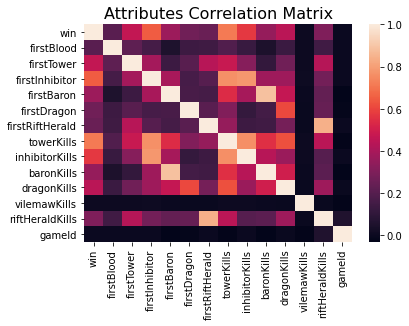

In [17]:
corr = df_results.corr()

ax = sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

ax.set_title("Attributes Correlation Matrix", fontsize = 16)

Podemos observar uma forte correlação com a vitória na partida:
1.   towerKills
2.   riftHeraldKills
3.   firstInhibitor
4.   dragonKills



##### Bar chart informativos entre correlações x wins

Com essa visualizaco eh possivel vermos a correlacao entre as principais 

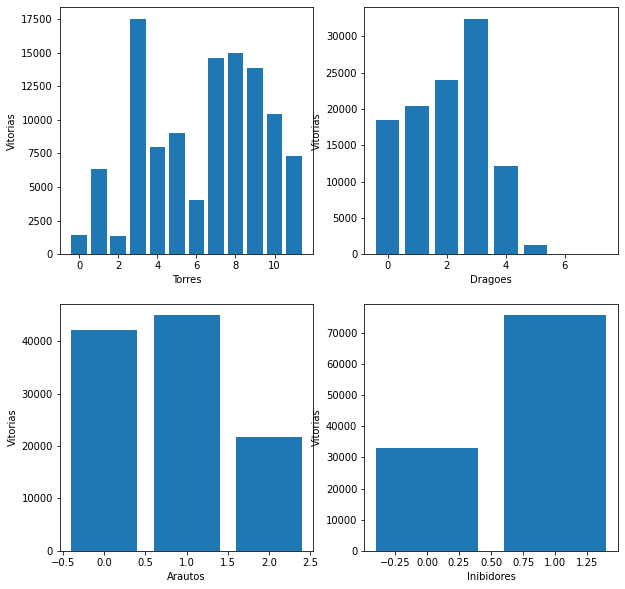

In [18]:
width = 0.35  # the width of the bars

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# tower/wins
axs[0,0].bar(df_results['towerKills'].unique(), df_results.groupby('towerKills').sum('win')['win'])
axs[0,0].set_xlabel("Torres")
axs[0,0].set_ylabel("Vitorias")

# dragon/wins
axs[0,1].bar(df_results['dragonKills'].unique(), df_results.groupby('dragonKills').sum('win')['win'])
axs[0,1].set_xlabel("Dragoes")
axs[0,1].set_ylabel("Vitorias")

# herald/wins
axs[1,0].bar(df_results['riftHeraldKills'].unique(), df_results.groupby('riftHeraldKills').sum('win')['win'])
axs[1,0].set_xlabel("Arautos")
axs[1,0].set_ylabel("Vitorias")

# baron/wins
axs[1,1].bar(df_results['firstInhibitor'].unique(), df_results.groupby('firstInhibitor').sum('win')['win'])
axs[1,1].set_xlabel("Inibidores")
axs[1,1].set_ylabel("Vitorias")

plt.show()



**Towers x Wins**
- A equipe que destruiu mais torres, consequentemente apresenta melhores resultados (vitórias)
- Uma observação válida para esta situação é que ao destruir 01 torre, se equipara com a proporção de destruir 11. 

- A provavel explicação para essa situação é que a equipe que estava em desvantagem no jogo, e provavelmente havia perdido sua 1ª torre há pouco, rendeu-se, desta forma, finalizando o jogo e dando a vitória pro outro time.

**DragonKills x Wins**
- A equipe que atingir a marca de 3 dragons no jogo, tem 5 vezes mais chance de ganhar. 

- Uma observação de por que 4 dragons ter uma chance menor de a de 3, pode ser devido a estratégia e velocidade do jogo (não sendo possível fazer um 4º dragon, pois o jogo finalizou antes disso ou não proporcionou momentos oportunos para que a equipe faça o 4º dragon)

**Heralds x Wins**

- Este é o item que melhor proporciona uma indicação de qual equipe ganhará o jogo, pois trata-se de um 'side objective' do jogo, que sendo bem controlado por uma equipe, rendeu de 4 a 6 vezes mais vitórias.

**Barons x Wins**

- Nesta comparação podemos observar a ausência de importância do objetivo "matar o Baron" dentro da partida. Desta forma, equipes que se empenham em realizar esse objetivo, tendem a perder as partidas.


## Modelagem

### Decision Treee

Aplicacao do modelo Decision Tree ao dataframe de jogos para saber as caracteristicas que levam a uma vitoria.

Primeiro faremos a selecao de features que usaremos para treinar o modelo e a variavel alvo a ser predita.

In [42]:

columns = [
 'win','firstBlood','firstTower','firstInhibitor','firstBaron',
 'firstDragon','firstRiftHerald','towerKills','inhibitorKills','baronKills',
 'dragonKills','vilemawKills','riftHeraldKills','gameId'
]

X = df_results[[col for col in df_results.columns if col != 'win' or col != 'gameId']]
y = df_,'gameId'"]

Dividir os dados entre treinamento e avaliacao:

In [53]:
X.columns

Index(['firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
       'firstDragon', 'firstRiftHerald', 'towerKills', 'inhibitorKills',
       'baronKills', 'dragonKills', 'vilemawKills', 'riftHeraldKills'],
      dtype='object')

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

Treinar modelo de Decision Tree

In [83]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [84]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.8632149022665256

In [85]:
import graphviz
from sklearn.tree import export_graphviz

my_tree = export_graphviz(clf, out_file=None, 
                              feature_names= ['firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
                                                'firstDragon', 'firstRiftHerald', 'towerKills', 'inhibitorKills',
                                                'baronKills', 'dragonKills', 'vilemawKills', 'riftHeraldKills'],  
                              class_names=["win", "false"],  
                              filled=True, rounded=True,  
                              special_characters=True)

graph = graphviz.Source(my_tree)
graph.render("LoLDecisionTree")

'LoLDecisionTree.pdf'